In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from tqdm.notebook import tqdm
import torch
import torch.nn

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using:', device)

# code to ease execution for the poor non-cuda devices of the world
if device == 'cuda':
    torchtypes=torch.cuda
    usecuda=True
else:
    torchtypes=torch
    usecuda=False

def safecuda(oo, *args, **kwargs):
    if usecuda:
        return oo.cuda(*args, **kwargs)
    else:
        return oo
    
from sith import SITH

# You might need to install seaborn if you haven't already
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

Using: cpu


In [2]:
# Import the data
ts = pd.read_csv('../data/mturk.csv', index_col=0)

In [149]:
def get_inputs_outputs(df, first_trial=4, mt_split=45):
    """Function for pulling one subject worth of data out of the 
    dataframe and formatting it for use with the sith and linear models.
    Since there are longitudinal dependencies in the task, the test data
    contains data from all of the trials and the train data contains 
    only data up to the split point specified by mt_split.
    Parameters
    ----------
    df: pandas.DataFrame
      The dataframe with the mturk data in it
    first_trial: int
      Which trial to start at, should be after the first mood rating
    mt_split: int
      Which trial to split the training and test data at
    
    Outputs
    -------
    subj_inputs_mtrain: torch.DoubleTensor
      Inputs for training
    subj_outputs_mtrain: torch.DoubleTensor
      Outputs for training
    subj_inputs_mtest: torch.DoubleTensor
      Inputs for testing
    subj_inputs_mtrain: torch.DoubleTensor
      Outputs for testing
    """
    df = df.copy().reset_index(drop=True)
    df['RPEdif'] = df.loc[:, ['Outcome1', 'Outcome2']].mean(1)-df.CertainAmount
    df['high_outcome'] = df.Actual == df.Outcome1
    df['low_outcome'] = df.Actual == df.Outcome2
    df['cert_outcome'] = df.Actual == df.CertainAmount

    df['prev_outcome'] = np.nan
    df['prev_high'] = np.nan
    df['prev_low'] = np.nan
    df['prev_cert'] = np.nan
    df['prev_mood'] = np.nan


    df.loc[1:, 'prev_outcome'] = df.Actual.values[:-1]
    df.loc[1:, 'prev_high'] = df.high_outcome.values[:-1]
    df.loc[1:, 'prev_low'] = df.low_outcome.values[:-1]
    df.loc[1:, 'prev_cert'] = df.cert_outcome.values[:-1]
    df.loc[1:, 'prev_mood'] = df.InterpHappiness.values[:-1]

    subj_inputs_mtrain = torch.DoubleTensor(df.loc[(df.time>=first_trial) & (df.time < mt_split), ['CertainAmount', 'Outcome1', 'Outcome2', 'RPEdif', 'prev_outcome', 'prev_high', 'prev_low', 'prev_cert']].values.astype(float))
    subj_outputs_mtrain = torch.DoubleTensor(df.loc[(df.time>=first_trial) & (df.time < mt_split), ['Gamble', 'InterpHappiness']].values)
    subj_inputs_mtest =  torch.DoubleTensor(df.loc[(df.time>=first_trial), ['CertainAmount', 'Outcome1', 'Outcome2', 'RPEdif', 'prev_outcome', 'prev_high', 'prev_low', 'prev_cert']].values.astype(float))
    subj_outputs_mtest = torch.DoubleTensor(df.loc[(df.time>=first_trial), ['Gamble', 'InterpHappiness']].values)
    return subj_inputs_mtrain, subj_outputs_mtrain, subj_inputs_mtest, subj_outputs_mtest

In [150]:
def train_model(model, inputs, outputs,
                optimizer,
                epochs=1500):
    loss_track = {"val":[],
                  "epoch":[],
                  "acc":[],
                  "name":[]}
    
    out1s = outputs[:,0]
    out2s = outputs[:,1]
    progress_bar = tqdm(range(int(epochs)))
    l1 = torch.nn.L1Loss()
    mse = torch.nn.MSELoss()
    
    for e in progress_bar:
        # Zero the gradient between each batch
        model.zero_grad()
        
        # Present an entire batch to the model
        choice, mood = model(inputs)
        
        # Measure loss via MSE for choice and L1 for mood
        loss = mse(choice, out1s) + l1(mood, out2s)
        
        # Adjust Weights
        if e == 0:
            loss.backward(create_graph=True, retain_graph=True)
        else:
            loss.backward()
        optimizer.step()
        
        # Record loss, epoch number, batch number in epoch, 
        # last accuracy measure, etc
        loss_track['val'].append(loss.mean().detach().cpu().numpy())
        loss_track['epoch'].append(e)
        loss_track['name'].append(model.__class__.__name__)
        
        acc = test_model(model, inputs, outputs)
        loss_track['acc'].append(acc)
        
        # Update progress_bar
        progress_bar.set_description("%i: Loss: %0.6f, Acc: %0.4f" % (e, loss_track['val'][-1], acc))
        
    return loss_track

def test_model(model, inputs, outputs):
    # Test for accuracy of choice
    
    choice,mood = model(inputs)

    # Accuracy: If the choice prob is greater than 0.5, call it a gamble
    correct = ((choice > 0.5) == (outputs[:,0] > 0.5)).sum().detach().cpu().numpy()
    
    acc = correct/outputs.shape[0]
    return acc

### input features for gambling task
1. previous outcome
1. high value
1. low value
1. certain value
1. h-l/2 - c
1. previous mood

### Output features
1. choice
2. mood

In [76]:
class SITHGambleModel(torch.nn.Module):
    """input shape: (sequence, 1)"""
    def __init__(self, sith_params, hidden_size):
        """
        Parameters
        ----------
        
            sith_params: dictionary
                A dictionary contianing all the parameters needed to setup the SITH layer.
            """
        super(SITHGambleModel, self).__init__()
        
        self.linput = torch.nn.Linear(sith_params['in_features'],sith_params['in_features'])
        
        self.sith = SITH(**sith_params)
        if usecuda:
            self.sith.cuda()
        
        num_taustars = self.sith.tau_star.shape[0]
        self.do1 = torch.nn.Dropout(0.2)
        self.linear1 = torch.nn.Linear(sith_params['in_features']*num_taustars, hidden_size)
        self.do2 = torch.nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(hidden_size, 2)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, inputs):
        self.sith.reset()
        
        batch_size = inputs.shape[0]
        
        #x = self.linput(inputs)
        x = self.sith(inputs).view(batch_size, -1)
        x = self.do1(x)
        x = self.linear1(x)
        x = self.do2(x)
        x = self.linear2(x)
        choice = x[:,0]
        mood = x[:,1]
        choice = self.sigmoid(choice)
        mood = self.sigmoid(mood)
        return choice, mood

In [77]:
class LinearGambleModel(torch.nn.Module):
    """input shape: (sequence, 1)"""
    def __init__(self, sith_params, hidden_size):
        """
        Parameters
        ----------
            sith_params: dictionary
                A dictionary contianing all the parameters needed to setup the SITH layer.
                It's not used in this model, but I implmented this lazily, so we need it 
                to initialize some variables
            """
        super(LinearGambleModel, self).__init__()
        
        
        self.sith = SITH(**sith_params)
        if usecuda:
            self.sith.cuda()
        
        num_taustars = self.sith.tau_star.shape[0]
        self.linput = torch.nn.Linear(sith_params['in_features'],sith_params['in_features']*num_taustars)

        self.do1 = torch.nn.Dropout(0.2)
        self.linear1 = torch.nn.Linear(sith_params['in_features']*num_taustars, hidden_size)
        self.do2 = torch.nn.Dropout(0.2)
        self.linear2 = torch.nn.Linear(hidden_size, 2)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, inputs):
        self.sith.reset()
        
        batch_size = inputs.shape[0]
        
        x = self.linput(inputs)
        #x = self.sith(inputs).view(batch_size, -1)
        x = self.do1(x)
        x = self.linear1(x)
        x = self.do2(x)
        x = self.linear2(x)
        choice = x[:,0]
        mood = x[:,1]
        choice = self.sigmoid(choice)
        mood = self.sigmoid(mood)
        return choice, mood

In [128]:
# make sure all models use the same general parameters
rep_size = 8
hidden_size = 50
in_size = subj_inputs_mtest.shape[1]

In [129]:
orig_sith_params ={"in_features":in_size,
              "tau_min":1, "tau_max":40, "k":10,
              "ntau":150, "g":0.0,
              # we want 8 taustars, so we divide the ntau by the
              # rep_size to get our desired T_every
              "T_every":int(150/rep_size)+1, "alpha":1.0, 'ttype':torchtypes.DoubleTensor}
sith_params ={"in_features":in_size,
              "tau_min":1, "tau_max":40, "k":10,
              "ntau":150, "g":0.0,
              # we want 8 taustars, so we divide the ntau by the
              # rep_size to get our desired T_every
              "T_every":int(150/rep_size)+1, "alpha":1.0, 'ttype':torchtypes.DoubleTensor}
# This is only for making sure you pick the right parameters
sith_model = safecuda(SITHGambleModel(sith_params=sith_params, 
                             hidden_size=hidden_size)).double()
taustars = sith_model.sith.tau_star
print(taustars)
print(sith_model)

tensor([ 1.0000,  1.6006,  2.5620,  4.1008,  6.5638, 10.5062, 16.8166, 26.9170],
       dtype=torch.float64)
SITHGambleModel(
  (linput): Linear(in_features=8, out_features=8, bias=True)
  (sith): SITH(
    out_shape=(1, sequence_len, 8, 8)
    (lap): Laplace(8, 1-40 with 150 ntau, k=10, c=0.0251)
  )
  (do1): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=64, out_features=50, bias=True)
  (do2): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [130]:
linear_model = safecuda(LinearGambleModel(sith_params=sith_params, 
                             hidden_size=hidden_size)).double()
print(linear_model)

LinearGambleModel(
  (sith): SITH(
    out_shape=(1, sequence_len, 8, 8)
    (lap): Laplace(8, 1-40 with 150 ntau, k=10, c=0.0251)
  )
  (linput): Linear(in_features=8, out_features=64, bias=True)
  (do1): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=64, out_features=50, bias=True)
  (do2): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=50, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)


In [131]:
# Train on one full subject
subj_inputs_mtrain, subj_outputs_mtrain, subj_inputs_mtest, subj_outputs_mtest = get_inputs_outputs(ts.loc[ts.subject_id == 10001], mt_split=100)

In [132]:
print("Starting SITH")
optim = torch.optim.Adam(sith_model.parameters())
perf_sith = train_model(sith_model, subj_inputs_mtrain, subj_outputs_mtrain, optimizer=optim, epochs=2000)

Starting SITH


In [133]:
print("Starting Linear")
optim = torch.optim.Adam(linear_model.parameters())
perf_linear = train_model(linear_model, subj_inputs_mtrain, subj_outputs_mtrain, optimizer=optim, epochs=2000)

Starting Linear


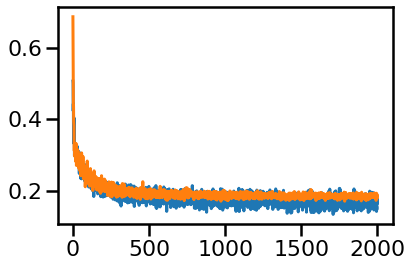

In [134]:
plt.plot(perf_sith['epoch'], perf_sith['val'])
plt.plot(perf_linear['epoch'], perf_linear['val'])

In [135]:
pred_choice, pred_mood = sith_model(subj_inputs_mtrain)
linpred_choice, linpred_mood = linear_model(subj_inputs_mtrain)

(-0.05, 1.05)

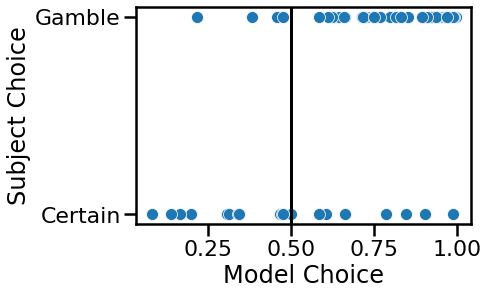

In [136]:

ax  = sns.scatterplot( pred_choice.detach().numpy(), subj_outputs_mtrain[:,0],)
ax.set_yticks([0,1])
ax.set_yticklabels([ 'Certain', 'Gamble'])
ax.set_ylabel('Subject Choice')
ax.set_xlabel('Model Choice')
ylims = ax.get_ylim()
ax.vlines(0.5, ylims[0], ylims[1], 'black')
ax.set_ylim(ylims)

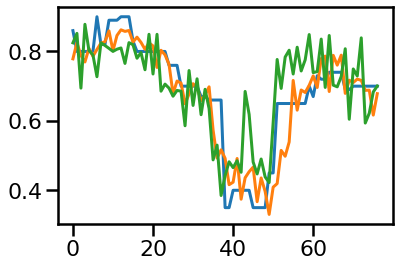

In [138]:
plt.plot(subj_outputs_mtrain[:,1])
plt.plot(pred_mood.detach().numpy())
plt.plot(linpred_mood.detach().numpy())


In [139]:
# Now train on half of a new subject
subj_inputs_mtrain, subj_outputs_mtrain, subj_inputs_mtest, subj_outputs_mtest = get_inputs_outputs(ts.loc[ts.subject_id == 10002], mt_split=45)

In [140]:
print("Starting SITH")
optim = torch.optim.Adam(sith_model.parameters())
perf_sith = train_model(sith_model, subj_inputs_mtrain, subj_outputs_mtrain, optimizer=optim, epochs=2000)

Starting SITH


In [141]:
print("Starting Linear")
optim = torch.optim.Adam(linear_model.parameters())
perf_linear = train_model(linear_model, subj_inputs_mtrain, subj_outputs_mtrain, optimizer=optim, epochs=2000)

Starting Linear


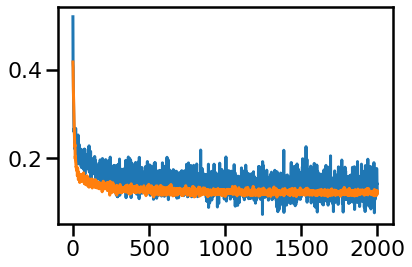

In [142]:
plt.plot(perf_sith['epoch'], perf_sith['val'])
plt.plot(perf_linear['epoch'], perf_linear['val'])

In [143]:
pred_choice, pred_mood = sith_model(subj_inputs_mtest)
linpred_choice, linpred_mood = linear_model(subj_inputs_mtest)

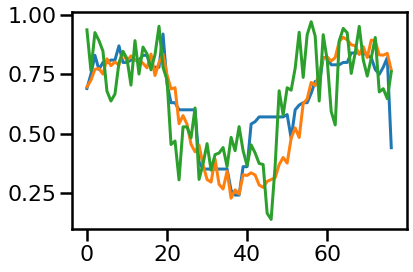

In [145]:
plt.plot(subj_outputs_mtest[:,1])
plt.plot(pred_mood.detach().numpy())
plt.plot(linpred_mood.detach().numpy())


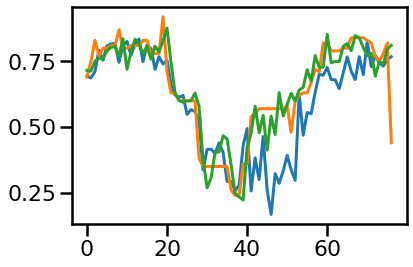

In [67]:
plt.plot(pred_mood.detach().numpy())
plt.plot(subj_outputs_mtest[:,1])
plt.plot(linpred_mood.detach().numpy())


In [146]:
# look at a completely new subject
subj_inputs_mtrain, subj_outputs_mtrain, subj_inputs_mtest, subj_outputs_mtest = get_inputs_outputs(ts.loc[ts.subject_id == 10007], mt_split=45)


In [147]:
pred_choice, pred_mood = sith_model(subj_inputs_mtest)
linpred_choice, linpred_mood = linear_model(subj_inputs_mtest)

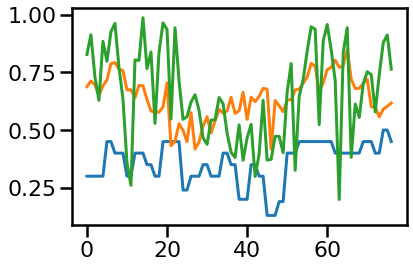

In [148]:
plt.plot(subj_outputs_mtest[:,1])

plt.plot(pred_mood.detach().numpy())
plt.plot(linpred_mood.detach().numpy())


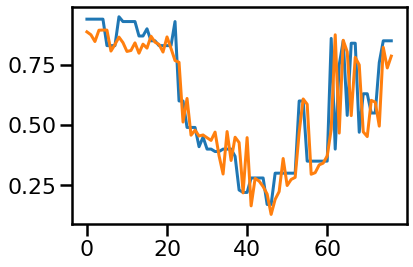

In [73]:
#plt.plot(pred_mood.detach().numpy())
plt.plot(subj_outputs_mtest[:,1])
plt.plot(linpred_mood.detach().numpy())


In [223]:
out_choice, out_mood = sith_model(subj_inputs)

(-0.05, 1.05)

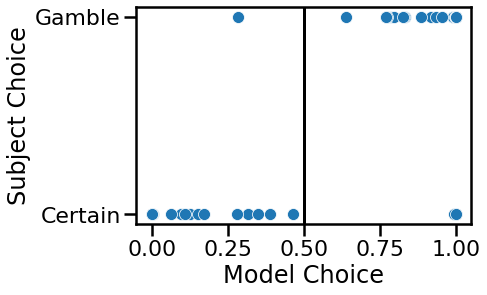

In [224]:

ax  = sns.scatterplot( out_choice.detach().numpy(), subj_outputs[:,0],)
ax.set_yticks([0,1])
ax.set_yticklabels([ 'Certain', 'Gamble'])
ax.set_ylabel('Subject Choice')
ax.set_xlabel('Model Choice')
ylims = ax.get_ylim()
ax.vlines(0.5, ylims[0], ylims[1], 'black')
ax.set_ylim(ylims)

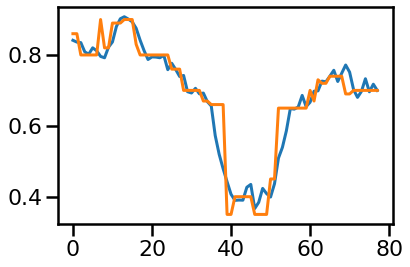

In [225]:
plt.plot(out_mood.detach().numpy())
plt.plot(subj_outputs[:,1])

In [226]:
sith_model.sith.tau_star.detach().numpy()

array([ 1.        ,  3.53472885, 12.49430803])

In [227]:
sith_model.sith.parameters

<bound method Module.parameters of SITH(
  out_shape=(1, sequence_len, 3, 8)
  (lap): Laplace(8, 1-40 with 150 ntau, k=10, c=0.0251)
)>

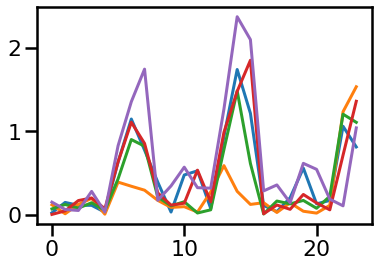

In [228]:
plt.plot(np.abs(sith_model.linear1.weight[0].detach().numpy()))
plt.plot(np.abs(sith_model.linear1.weight[1].detach().numpy()))
plt.plot(np.abs(sith_model.linear1.weight[2].detach().numpy()))
plt.plot(np.abs(sith_model.linear1.weight[3].detach().numpy()))
plt.plot(np.abs(sith_model.linear1.weight[4].detach().numpy()))

In [230]:
sith_model.linear2.weight.shape

torch.Size([2, 5])